# 1.0 Useful classes and functions

In [5]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from imutils import paths
import numpy as np
import progressbar
import h5py
import random
import os

## 1.1 HDF5DatasetWriter

In [6]:
# import the necessary packages
import h5py
import os

class HDF5DatasetWriter:
  def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    """
    The constructor to HDF5DatasetWriter accepts four parameters, two of which are optional.
    
    Args:
    dims: controls the dimension or shape of the data we will be storing in the dataset.
    if we were storing the (flattened) raw pixel intensities of the 28x28 = 784 MNIST dataset, 
    then dims=(70000, 784).
    outputPath: path to where our output HDF5 file will be stored on disk.
    datakey: The optional dataKey is the name of the dataset that will store
    the data our algorithm will learn from.
    bufSize: controls the size of our in-memory buffer, which we default to 1,000 feature
    vectors/images. Once we reach bufSize, we’ll flush the buffer to the HDF5 dataset.
    """

    # check to see if the output path exists, and if so, raise
    # an exception
    if os.path.exists(outputPath):
      raise ValueError("The supplied `outputPath` already "
        "exists and cannot be overwritten. Manually delete "
        "the file before continuing.", outputPath)

    # open the HDF5 database for writing and create two datasets:
    # one to store the images/features and another to store the
    # class labels
    self.db = h5py.File(outputPath, "w")
    self.data = self.db.create_dataset(dataKey, dims,dtype="float",compression='gzip')
    self.labels = self.db.create_dataset("labels", (dims[0],),dtype="int")

    # store the buffer size, then initialize the buffer itself
    # along with the index into the datasets
    self.bufSize = bufSize
    self.buffer = {"data": [], "labels": []}
    self.idx = 0

  def add(self, rows, labels):
    # add the rows and labels to the buffer
    self.buffer["data"].extend(rows)
    self.buffer["labels"].extend(labels)

    # check to see if the buffer needs to be flushed to disk
    if len(self.buffer["data"]) >= self.bufSize:
      self.flush()

  def flush(self):
    # write the buffers to disk then reset the buffer
    i = self.idx + len(self.buffer["data"])
    self.data[self.idx:i] = self.buffer["data"]
    self.labels[self.idx:i] = self.buffer["labels"]
    self.idx = i
    self.buffer = {"data": [], "labels": []}

  def storeClassLabels(self, classLabels):
    # create a dataset to store the actual class label names,
    # then store the class labels
    dt = h5py.special_dtype(vlen=str) # `vlen=unicode` for Py2.7
    labelSet = self.db.create_dataset("label_names",(len(classLabels),), dtype=dt)
    labelSet[:] = classLabels

  def close(self):
    # check to see if there are any other entries in the buffer
    # that need to be flushed to disk
    if len(self.buffer["data"]) > 0:
      self.flush()

    # close the dataset
    self.db.close()

## 1.2 Image to Array

In [7]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

## 1.3 AspectAware

In [8]:
# import the necessary packages
import imutils
import cv2

# useful class to help the resize of images
class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# grab the dimensions of the image and then initialize
		# the deltas to use when cropping
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		# if the width is smaller than the height, then resize
		# along the width (i.e., the smaller dimension) and then
		# update the deltas to crop the height to the desired
		# dimension
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		# otherwise, the height is smaller than the width so
		# resize along the height and then update the deltas
		# crop along the width
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		# now that our images have been resized, we need to
		# re-grab the width and height, followed by performing
		# the crop
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		# finally, resize the image to the provided spatial
		# dimensions to ensure our output image is always a fixed
		# size
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

## 1.4 Mean preprocessor

Let’s get started with the mean pre-processor. We will learn how to convert an image
dataset to HDF5 format – part of this conversion involved computing the average Red, Green, and Blue pixel intensities across all images in the training dataset. Now that we have these averages, we are going to perform a pixel-wise subtraction of these values from our input images as a **form of data normalization**.

In [9]:
# import the necessary packages
import cv2

class MeanPreprocessor:
	def __init__(self, rMean, gMean, bMean):
		# store the Red, Green, and Blue channel averages across a
		# training set
		self.rMean = rMean
		self.gMean = gMean
		self.bMean = bMean

	def preprocess(self, image):
		# split the image into its respective Red, Green, and Blue
		# channels
		(B, G, R) = cv2.split(image.astype("float32"))

		# subtract the means for each channel
		R -= self.rMean
		G -= self.gMean
		B -= self.bMean

    # Keep in mind that OpenCV represents images in BGR order
		# merge the channels back together and return the image
		return cv2.merge([B, G, R])

## 1.5 Patch preprocessing

The PatchPreprocessor is responsible for randomly sampling MxN regions of an image during the training process. We apply patch preprocessing when the spatial dimensions of our input images are larger than what the CNN expects – this is a common technique to help reduce overfitting, and is, therefore, **a form of regularization**. Instead of using the entire image during training, we instead crop a random portion of it and pass it to the network.

As you will see, we will construct an HDF5 dataset of Kaggle Dogs vs. Cats images where each image is 256x256 pixels. However, the AlexNet architecture that we’ll be implementing later in this lesson can only accept images of size 227x227 pixels. This is an excellent opportunity to perform data augmentation by randomly cropping a 227x227 region from the 256x256 image during training using PatchPreprocessor.

In [10]:
# import the necessary packages
from sklearn.feature_extraction.image import extract_patches_2d

class PatchPreprocessor:
	def __init__(self, width, height):
		# store the target width and height of the image
		self.width = width
		self.height = height

	def preprocess(self, image):
		# extract a random crop from the image with the target width
		# and height
		return extract_patches_2d(image, (self.height, self.width),
			max_patches=1)[0]

## 1.6 Crop preprocessor

Next, we need to define a CropPreprocessor responsible for computing the 10-crops for oversampling. During the evaluating phase of our CNN, we’ll crop the four corners of the input image + the center region and then take their corresponding horizontal flips, for a total of ten samples per input image.

These ten samples will be passed through the CNN, and then the probabilities averaged.
Applying this over-sampling method tends to include 1-2 percent increases in classification accuracy (and in some cases, even higher).

In [11]:
# import the necessary packages
import numpy as np
import cv2

class CropPreprocessor:
	def __init__(self, width, height, horiz=True, inter=cv2.INTER_AREA):
		# store the target image width, height, whether or not
		# horizontal flips should be included, along with the
		# interpolation method used when resizing
		self.width = width
		self.height = height
		self.horiz = horiz
		self.inter = inter

	def preprocess(self, image):
		# initialize the list of crops
		crops = []

		# grab the width and height of the image then use these
		# dimensions to define the corners of the image based
		(h, w) = image.shape[:2]
		coords = [
			[0, 0, self.width, self.height],
			[w - self.width, 0, w, self.height],
			[w - self.width, h - self.height, w, h],
			[0, h - self.height, self.width, h]]

		# compute the center crop of the image as well
		dW = int(0.5 * (w - self.width))
		dH = int(0.5 * (h - self.height))
		coords.append([dW, dH, w - dW, h - dH])

		# loop over the coordinates, extract each of the crops,
		# and resize each of them to a fixed size
		for (startX, startY, endX, endY) in coords:
			crop = image[startY:endY, startX:endX]
			crop = cv2.resize(crop, (self.width, self.height),
				interpolation=self.inter)
			crops.append(crop)

		# check to see if the horizontal flips should be taken
		if self.horiz:
			# compute the horizontal mirror flips for each crop
			mirrors = [cv2.flip(c, 1) for c in crops]
			crops.extend(mirrors)

		# return the set of crops
		return np.array(crops)

## 1.7 HDF5 dataset generators

Before we can implement the AlexNet architecture and train it on the Kaggle Dogs vs. Cats dataset, we first need to define a class responsible for yielding batches of images and labels from our HDF5 dataset. Section 1.1 discussed how to convert a set of images residing on disk into an HDF5 dataset – but how do we get them back out again? The answer is to define an **HDF5DatasetGenerator** class.

Previously, all of our image datasets could be loaded into memory so we could rely on Keras generator utilities to yield our batches of images and corresponding labels. However, now that our datasets are too large to fit into memory, we need to handle implementing this generator ourselves.

In [12]:
# import the necessary packages
from tensorflow.keras.utils import to_categorical
import numpy as np
import h5py

class HDF5DatasetGenerator:
	def __init__(self, dbPath, batchSize, preprocessors=None, aug=None, binarize=True, classes=2):
		# store the batch size, preprocessors, and data augmentor,
		# whether or not the labels should be binarized, along with
		# the total number of classes
		self.batchSize = batchSize
		self.preprocessors = preprocessors
		self.aug = aug
		self.binarize = binarize
		self.classes = classes

		# open the HDF5 database for reading and determine the total
		# number of entries in the database
		self.db = h5py.File(dbPath, "r")
		self.numImages = self.db["labels"].shape[0]

	def generator(self, passes=np.inf):
		# initialize the epoch count
		epochs = 0

		# keep looping infinitely -- the model will stop once we have
		# reach the desired number of epochs
		while epochs < passes:
			# loop over the HDF5 dataset
			for i in np.arange(0, self.numImages, self.batchSize):
				# extract the images and labels from the HDF dataset
				images = self.db["images"][i: i + self.batchSize]
				labels = self.db["labels"][i: i + self.batchSize]

				# check to see if the labels should be binarized
				if self.binarize:
					labels = to_categorical(labels,
						self.classes)

				# check to see if our preprocessors are not None
				if self.preprocessors is not None:
					# initialize the list of processed images
					procImages = []

					# loop over the images
					for image in images:
						# loop over the preprocessors and apply each
						# to the image
						for p in self.preprocessors:
							image = p.preprocess(image)

						# update the list of processed images
						procImages.append(image)

					# update the images array to be the processed
					# images
					images = np.array(procImages)

				# if the data augmenator exists, apply it
				if self.aug is not None:
					(images, labels) = next(self.aug.flow(images,
						labels, batch_size=self.batchSize))

				# yield a tuple of images and labels
				yield (images, labels)

			# increment the total number of epochs
			epochs += 1

	def close(self):
		# close the database
		self.db.close()

## 1.8 Simple preprocessor

In [13]:
# import the necessary packages
import cv2

class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

## 1.9 Training monitor

In [14]:
# import the necessary packages
from tensorflow.keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os

class TrainingMonitor(BaseLogger):
	def __init__(self, figPath, jsonPath=None, startAt=0):
		# store the output path for the figure, the path to the JSON
		# serialized file, and the starting epoch
		super(TrainingMonitor, self).__init__()
		self.figPath = figPath
		self.jsonPath = jsonPath
		self.startAt = startAt

	def on_train_begin(self, logs={}):
		# initialize the history dictionary
		self.H = {}

		# if the JSON history path exists, load the training history
		if self.jsonPath is not None:
			if os.path.exists(self.jsonPath):
				self.H = json.loads(open(self.jsonPath).read())

				# check to see if a starting epoch was supplied
				if self.startAt > 0:
					# loop over the entries in the history log and
					# trim any entries that are past the starting
					# epoch
					for k in self.H.keys():
						self.H[k] = self.H[k][:self.startAt]

	def on_epoch_end(self, epoch, logs={}):
		# loop over the logs and update the loss, accuracy, etc.
		# for the entire training process
		for (k, v) in logs.items():
			l = self.H.get(k, [])
			l.append(float(v))
			self.H[k] = l

		# check to see if the training history should be serialized
		# to file
		if self.jsonPath is not None:
			f = open(self.jsonPath, "w")
			f.write(json.dumps(self.H))
			f.close()

		# ensure at least two epochs have passed before plotting
		# (epoch starts at zero)
		if len(self.H["loss"]) > 1:
			# plot the training loss and accuracy
			N = np.arange(0, len(self.H["loss"]))
			plt.style.use("ggplot")
			plt.figure()
			plt.plot(N, self.H["loss"], label="train_loss")
			plt.plot(N, self.H["val_loss"], label="val_loss")
			plt.plot(N, self.H["accuracy"], label="train_acc")
			plt.plot(N, self.H["val_accuracy"], label="val_acc")
			plt.title("Training Loss and Accuracy [Epoch {}]".format(
				len(self.H["loss"])))
			plt.xlabel("Epoch #")
			plt.ylabel("Loss/Accuracy")
			plt.legend()

			# save the figure
			plt.savefig(self.figPath)
			plt.close()

## 1.10 Rank accuracy


In [15]:
# import the necessary packages
import numpy as np

def rank5_accuracy(preds, labels):
	# initialize the rank-1 and rank-5 accuracies
	rank1 = 0
	rank5 = 0

	# loop over the predictions and ground-truth labels
	for (p, gt) in zip(preds, labels):
		# sort the probabilities by their index in descending
		# order so that the more confident guesses are at the
		# front of the list
		p = np.argsort(p)[::-1]

		# check if the ground-truth label is in the top-5
		# predictions
		if gt in p[:5]:
			rank5 += 1

		# check to see if the ground-truth is the #1 prediction
		if gt == p[0]:
			rank1 += 1

	# compute the final rank-1 and rank-5 accuracies
	rank1 /= float(len(preds))
	rank5 /= float(len(preds))

	# return a tuple of the rank-1 and rank-5 accuracies
	return (rank1, rank5)

## 1.11 SimpleDatasetLoader

In [16]:
# import the necessary packages
import numpy as np
import cv2
import os

# helper to load images
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

# 2.0 Working with HDFS and large datasets

In [1]:
# download FaceMask dataset
!gdown https://drive.google.com/uc?id=1w0ur8APf74M1DFjSidhsKzeT3gXjWRty

Downloading...
From: https://drive.google.com/uc?id=1w0ur8APf74M1DFjSidhsKzeT3gXjWRty
To: /content/facemask_data.zip
346MB [00:04, 78.9MB/s]


In [2]:
!unzip facemask_data.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask

In [3]:
!mkdir facemask
!mkdir facemask/hdf5
!mkdir facemask/output
!mv Face\ Mask\ Dataset/Train facemask/
!mv Face\ Mask\ Dataset/Test facemask/
!mv Face\ Mask\ Dataset/Validation facemask/

In [17]:
# List all subdirectories
base_dir = os.getcwd()
print(base_dir)

# Obtain list of subdirectories and directory path for train set
train_dir = os.chdir('facemask/Train')
train_dir_list = os.listdir(train_dir)
train_dir = os.getcwd()
os.chdir(base_dir)

# Obtain list of subdirectories and directory path for test set
test_dir = os.chdir('facemask/Test')
test_dir_list = os.listdir(test_dir)
test_dir = os.getcwd()
os.chdir(base_dir)

# Obtain list of subdirectories and directory path for validation set
val_dir = os.chdir('facemask/Validation')
val_dir_list = os.listdir(val_dir)
val_dir = os.getcwd()
os.chdir(base_dir)

/content


In [18]:
# Rename all the files with the class embedded

# Train folder
os.chdir(train_dir)
for dir in train_dir_list:
    os.chdir(dir)
    for f in os.listdir(os.getcwd()):
        nf = f.split('.')
        os.rename(f, '../' + dir + '_' + nf[0] +  '.png') # from 'name.png' to 'class_name.png'
    os.chdir('../')
    os.rmdir(dir)
os.chdir(base_dir)

# Test folder
os.chdir(test_dir)
for dir in test_dir_list:
    os.chdir(dir)
    for f in os.listdir(os.getcwd()):
        nf = f.split('.')
        os.rename(f, '../' + dir + '_' + nf[0] +  '.png')
    os.chdir('../')
    os.rmdir(dir)
os.chdir(base_dir)

# Validation folder
os.chdir(val_dir)
for dir in val_dir_list:
    os.chdir(dir)
    for f in os.listdir(os.getcwd()):
        nf = f.split('.')
        os.rename(f, '../' + dir + '_' + nf[0] +  '.png')
    os.chdir('../')
    os.rmdir(dir)
os.chdir(base_dir)

In [ ]:
# Count number of images of people with mask in train set
!ls facemask/Train | wc -l

10000


In [ ]:
# Count number of images of people without mask in test set
!ls facemask/Test | wc -l

992


In [ ]:
# Count number of images of people without mask in validation set
!ls facemask/Validation | wc -l

800


In [ ]:
# define the paths to the images directory
TRAIN_IMAGES_PATH = "facemask/Train"
TEST_IMAGES_PATH = "facemask/Test"
VAL_IMAGES_PATH = "facemask/Validation"

# define the path to the output training, validation, and testing
# HDF5 files
TRAIN_HDF5 = "facemask/hdf5/train.hdf5"
VAL_HDF5 = "facemask/hdf5/val.hdf5"
TEST_HDF5 = "facemask/hdf5/test.hdf5"

# path to the output model file
MODEL_PATH = "facemask/vgg_facemask.model"

# define the path to the dataset mean
DATASET_MEAN = "facemask/facemask_mean.json"

# define the path to the output directory used for storing plots,
# classification reports, etc.
OUTPUT_PATH = "facemask/output"

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from imutils import paths
import numpy as np
import progressbar
import json
import cv2
import os

# grab the paths to the images
trainPaths = list(paths.list_images(TRAIN_IMAGES_PATH))
trainLabels = [p.split(os.path.sep)[-1].split("_")[0] for p in trainPaths]
le = LabelEncoder()
trainLabels = le.fit_transform(trainLabels)
print('\n')
print('Train labels: ', trainLabels)

testPaths = list(paths.list_images(TEST_IMAGES_PATH))
testLabels = [p.split(os.path.sep)[-1].split("_")[0] for p in testPaths]
le = LabelEncoder()
testLabels = le.fit_transform(testLabels)

valPaths = list(paths.list_images(VAL_IMAGES_PATH))
valLabels = [p.split(os.path.sep)[-1].split("_")[0] for p in valPaths]
le = LabelEncoder()
valLabels = le.fit_transform(valLabels)

# construct a list pairing the training, validation, and testing
# image paths along with their corresponding labels and output HDF5
# files
datasets = [
	("train", trainPaths, trainLabels, TRAIN_HDF5),
	("val", valPaths, valLabels, VAL_HDF5),
	("test", testPaths, testLabels, TEST_HDF5)]

# initialize the image pre-processor and the lists of RGB channel
# averages
aap = AspectAwarePreprocessor(224, 224)
(R, G, B) = ([], [], [])

# loop over the dataset tuples
for (dType, paths, labels, outputPath) in datasets:
	# create HDF5 writer
	print("[INFO] building {}...".format(outputPath))
	writer = HDF5DatasetWriter((len(paths), 224, 224, 3), outputPath)

	# initialize the progress bar
	widgets = ["Building Dataset: ", progressbar.Percentage(), " ",progressbar.Bar(), " ", progressbar.ETA()]
	pbar = progressbar.ProgressBar(maxval=len(paths),widgets=widgets).start()

	# loop over the image paths
	for (i, (path, label)) in enumerate(zip(paths, labels)):
		# load the image and process it
		image = cv2.imread(path)
		image = aap.preprocess(image)

		# if we are building the training dataset, then compute the
		# mean of each channel in the image, then update the
		# respective lists
		if dType == "train":
			(b, g, r) = cv2.mean(image)[:3]
			R.append(r)
			G.append(g)
			B.append(b)

		# add the image and label # to the HDF5 dataset
		writer.add([image], [label])
		pbar.update(i)

	# close the HDF5 writer
	pbar.finish()
	writer.close()

# construct a dictionary of averages, then serialize the means to a
# JSON file
print("[INFO] serializing means...")
D = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
f = open(DATASET_MEAN, "w")
f.write(json.dumps(D))
f.close()

Building Dataset:   0% |                                       | ETA:   0:00:21



Train labels:  [0 1 0 ... 1 1 0]
[INFO] building facemask/hdf5/train.hdf5...


Building Dataset: 100% |#######################################| Time:  0:03:46
Building Dataset:  19% |#######                                | ETA:   0:00:00

[INFO] building facemask/hdf5/val.hdf5...


Building Dataset: 100% |#######################################| Time:  0:00:00
Building Dataset:  16% |######                                 | ETA:   0:00:00

[INFO] building facemask/hdf5/test.hdf5...


Building Dataset: 100% |#######################################| Time:  0:00:01


[INFO] serializing means...


In [ ]:
!du -h

In [20]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls facemask

In [ ]:
# copy hdf5 files for your google drive
!cp -r facemask/hdf5/ /content/drive/MyDrive/Colab\ Notebooks/ML/FaceMask/facemask
!cp -r facemask/facemask_mean.json /content/drive/MyDrive/Colab\ Notebooks/ML/FaceMask/facemask
!cp -r facemask/output/ /content/drive/MyDrive/Colab\ Notebooks/ML/FaceMask/facemask

# 3.0 Transfer learning from VGG19

In [21]:
# 
# only in case load data from drive
#
!mkdir facemask
!cp -r /content/drive/MyDrive/Colab\ Notebooks/ML/FaceMask/facemask/hdf5 facemask
!cp -r /content/drive/MyDrive/Colab\ Notebooks/ML/FaceMask/facemask/output facemask
!cp /content/drive/MyDrive/Colab\ Notebooks/ML/FaceMask/facemask/facemask_mean.json facemask_mean.json

mkdir: cannot create directory ‘facemask’: File exists


In [ ]:
!pip install wandb

     |████████████████████████████████| 2.1MB 11.1MB/s 
     |████████████████████████████████| 133kB 41.0MB/s 
     |████████████████████████████████| 163kB 37.1MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=feaa931cb1840a6f17fbef4b9f99afe91b53f4840980aad995d361789c88f925
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=79041b503ca1346ef4d9705238a19a4ee6775b06d61dc067c33ed92214dfa82d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [ ]:
import wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


If we would like to train a VGG19 net from scratch that would take a really long time (we are talking hours or even days).That is when transfer learning technique comes in handy.

With transfer learning we don't need to train the VGG19 network from scratch, we can load its state from the ImageNet competition and change only the top layers (the fully conected layers), training this last part according to our problem.

By doing that we maitain its capacity of extracting features from the image, but we no longer keep the decision making part because we want to make our own decisions (is the person in the image wearing mask?)

### 3.1 Removing the top layers of VGG19

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from imutils import paths
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
import numpy as np
import progressbar
import h5py
import random
import os

In [ ]:
# whether or not to include top of CNN
include_top = 0

# load the ResNet50 network
print("[INFO] loading network...")
model = VGG19(weights="imagenet", include_top= include_top > 0, input_shape=(224,224,3))
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
80142336/80134624 [==============================] - 1s 0us/step
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	Conv2D
[INFO] 11	MaxPooling2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	Conv2D
[INFO] 16	MaxPooling2D
[INFO] 17	Conv2D
[INFO] 18	Conv2D
[INFO] 19	Conv2D
[INFO] 20	Conv2D
[INFO] 21	MaxPooling2D


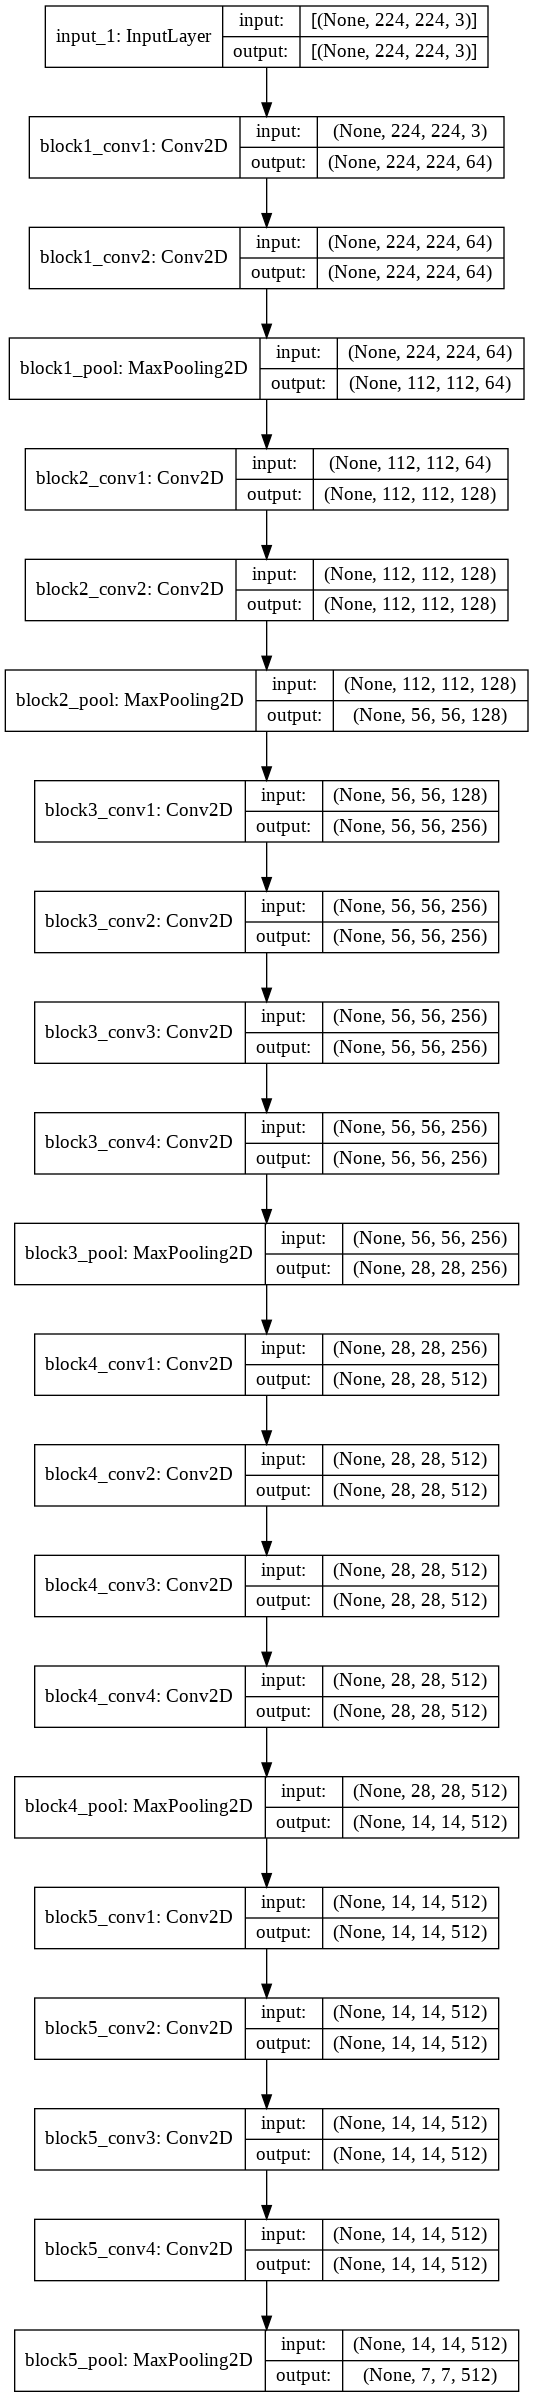

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## 3.2 Creating our fully connected network

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, D):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(D, activation="relu", kernel_initializer='he_uniform')(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

Once we defined the base architecture of our fully connected network we will create it.

It is important to note three things:

1. We preprocess the images to make them fit for going into the VGG19
2. We generate batches of images with the HDF5 generator and we apply data augmentation to improve generalization performance
3. We froze the VGG19 layers to train only the fully connected network

We can define some callbacks to log metrics with Wandb at every step of training (WandbCallback only updates at each epoch):

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    #def on_train_batch_begin(self, batch, logs=None):
    #    print("\nTraining: batch ", batch)    

    def on_train_batch_end(self, batch, logs=None):
        wandb.log({'loss':logs['loss'], 'accuracy':logs['accuracy']})
        #keys = list(logs.keys())
        #print("...Training: end of batch {}; got log keys: {}".format(batch, keys))
    
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({'val_loss':logs['val_loss'], 'val_accuracy':logs['val_accuracy']})
        #keys = list(logs.keys())
        #print("End epoch {} of training; got log keys: {}".format(epoch, keys))

In [ ]:
#%%wandb
# import the necessary packages
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from wandb.keras import WandbCallback

import json
import os

# Init wandb
wandb.init(project='FaceMask', name='VGG19_frozen')
config = wandb.config
config.update({"epochs" : 2, "batch_size": 128, "lr" : 0.001, 'D': 256, 'first_unfronzen_layer':-1})

# Configurations related to checkpoint
# resume or not the model
resume = False


# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# load the RGB means for the training set
means = json.loads(open(DATASET_MEAN).read())

# initialize the image preprocessors
sp = SimplePreprocessor(224, 224)
pp = PatchPreprocessor(224, 224)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

#batch_size = 128

# initialize the training and validation dataset generators
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, batchSize=config.batch_size, aug=aug,preprocessors=[pp, mp, iap], classes=2)
valGen = HDF5DatasetGenerator(VAL_HDF5, batchSize=config.batch_size, preprocessors=[sp, mp, iap], classes=2)

# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
num_classes = 2
headModel = FCHeadNet.build(model, num_classes, config.D)

# place the head FC model on top of the base model -- this will
# become the actual model we will train
final_model = Model(inputs=model.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")

# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(lr=config.lr)
final_model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
print("[INFO] training model...")
history = final_model.fit(trainGen.generator(),
          steps_per_epoch=trainGen.numImages // 128,
          validation_data=valGen.generator(),
          validation_steps=valGen.numImages // 128,
          epochs=config.epochs,
          max_queue_size=10,
          callbacks=[CustomCallback()],# WandbCallback(data_type="image", labels=['WithMask', 'WithoutMask'])]
          verbose=1)

# save the model to file
print("[INFO] serializing model...")
final_model.save(MODEL_PATH, overwrite=True)

# close the HDF5 datasets
trainGen.close()
valGen.close()

loss,0.20733
accuracy,0.9918
_runtime,626
_timestamp,1619544566
_step,157
val_loss,0.10895
val_accuracy,0.99609


loss,▇▄▃▃█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▁█
val_accuracy,█▁


[INFO] compiling model...
[INFO] training model...
Epoch 1/2
78/78 [==============================] - 304s 4s/step - loss: 1.5266 - accuracy: 0.9491 - val_loss: 0.0022 - val_accuracy: 0.9987
Epoch 2/2
78/78 [==============================] - 303s 4s/step - loss: 0.2500 - accuracy: 0.9920 - val_loss: 0.0025 - val_accuracy: 0.9987
[INFO] serializing model...
INFO:tensorflow:Assets written to: facemask/vgg_facemask.model/assets


## 3.3 Fine-tuning

Once we trained our fully conected network we can see that the results are really good, but what if we train some layers of the VGG19? Will the results get even better? There is only one way to find out.

We unfroze the layers 17 to 21 so they could also be trained and trained the model for 5 epochs.

In [ ]:
wandb.init(project='FaceMask', name='VGG19_unfrozen')
config = wandb.config
config.update({"epochs" : 5, "batch_size": 128, "lr" : 0.001, 'D': 256, 'first_unfronzen_layer':17})

# initialize the training and validation dataset generators
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, 128, aug=aug,preprocessors=[pp, mp, iap], classes=2)
valGen = HDF5DatasetGenerator(VAL_HDF5, 128,preprocessors=[sp, mp, iap], classes=2)

# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[config.first_unfronzen_layer:]:
	layer.trainable = True

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=config.lr)
final_model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] fine-tuning model...")
# train the network
history = final_model.fit(trainGen.generator(),
          steps_per_epoch=trainGen.numImages // 128,
          validation_data=valGen.generator(),
          validation_steps=valGen.numImages // 128,
          epochs=config.epochs,
          max_queue_size=10,
          callbacks=[CustomCallback()],
          verbose=1)

# close the HDF5 datasets
trainGen.close()
valGen.close()

# save the model to file
print("[INFO] serializing model...")
final_model.save(MODEL_PATH, overwrite=True)

[INFO] re-compiling model...
[INFO] fine-tuning model...
Epoch 1/5
78/78 [==============================] - 310s 4s/step - loss: 0.0809 - accuracy: 0.9941 - val_loss: 2.2254e-04 - val_accuracy: 1.0000
Epoch 2/5
78/78 [==============================] - 309s 4s/step - loss: 0.1704 - accuracy: 0.9897 - val_loss: 0.0027 - val_accuracy: 0.9987
Epoch 3/5
78/78 [==============================] - 307s 4s/step - loss: 0.0166 - accuracy: 0.9971 - val_loss: 0.0033 - val_accuracy: 0.9987
Epoch 4/5
78/78 [==============================] - 306s 4s/step - loss: 0.0221 - accuracy: 0.9964 - val_loss: 8.1889e-04 - val_accuracy: 1.0000
Epoch 5/5
78/78 [==============================] - 306s 4s/step - loss: 0.0135 - accuracy: 0.9981 - val_loss: 5.8659e-04 - val_accuracy: 1.0000
[INFO] serializing model...
INFO:tensorflow:Assets written to: facemask/vgg_facemask.model/assets


## 3.4 Evaluating on Test Set

Now that we have a great model, we want to evaluate it on the test set.

For that, we used the Rank-1 accuracy method with the predictions from our model.

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np
import progressbar
import json

# load the RGB means for the training set
means = json.loads(open(DATASET_MEAN).read())

# initialize the image preprocessors
sp = SimplePreprocessor(224, 224)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
cp = CropPreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

# load the pretrained network
print("[INFO] loading model...")
prod_model = load_model(MODEL_PATH)

# initialize the testing dataset generator, then make predictions on
# the testing data
print("[INFO] predicting on test data (no crops)...")
testGen = HDF5DatasetGenerator(TEST_HDF5, 64,
                               preprocessors=[sp, mp, iap], classes=2)
predictions = prod_model.predict(testGen.generator(),
                            steps=testGen.numImages // 64, max_queue_size=10)

# compute the rank-1 and rank-5 accuracies
(rank1, _) = rank5_accuracy(predictions, testGen.db["labels"])
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))
testGen.close()


# re-initialize the testing set generator, this time excluding the
# `SimplePreprocessor`
testGen = HDF5DatasetGenerator(TEST_HDF5, 64,
                               preprocessors=[mp], classes=2)
predictions = []

# initialize the progress bar
widgets = ["Evaluating: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=testGen.numImages // 64,widgets=widgets).start()

# loop over a single pass of the test data
for (i, (images, labels)) in enumerate(testGen.generator(passes=1)):
	# loop over each of the individual images
	for image in images:
		# apply the crop preprocessor to the image to generate 10
		# separate crops, then convert them from images to arrays
		crops = cp.preprocess(image)
		crops = np.array([iap.preprocess(c) for c in crops],
			dtype="float32")

		# make predictions on the crops and then average them
		# together to obtain the final prediction
		pred = prod_model.predict(crops)
		predictions.append(pred.mean(axis=0))

	# update the progress bar
	pbar.update(i)

# compute the rank-1 accuracy
pbar.finish()
print("[INFO] predicting on test data (with crops)...")
(rank1, _) = rank5_accuracy(predictions, testGen.db["labels"])
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))
testGen.close()

[INFO] loading model...
[INFO] predicting on test data (no crops)...


Evaluating: N/A% |                                             | ETA:  --:--:--

[INFO] rank-1: 99.90%


Evaluating: 100% |#############################################| Time:  0:03:16


[INFO] predicting on test data (with crops)...
[INFO] rank-1: 99.80%


# 4.0 References

1. [Prof. Dr. Ivanovitch Silva's notebook on Cats and Dogs dataset using AlexNet and ResNet-50](https://github.com/ivanovitchm/imd1122/blob/main/Lesson%20%2315/%5BStep_1%5D_Lesson_15_Dogs_vs_Cats.ipynb)

2. [Face Mask Detection: VGG19 (using Transfer Learning) notebook from Kaggle contributor 'onmule'](https://www.kaggle.com/ommule/face-mask-detection-vgg19-transfer-learning#The-model-shows-a-very-low-loss-&-99.697)

3. [OS Module in Python with Examples - GeeksforGeeks](https://www.geeksforgeeks.org/os-module-python-examples/)

4. [Track Model Performance](https://wandb.ai/lavanyashukla/visualize-models/reports/Track-Model-Performance--Vmlldzo1NTk2MA)